# Assignment 4: Pipelines and Hyperparameter Tuning (32 total marks)
### Due: November 22 at 11:59pm

### Name: Sieu Eric Diep

### In this assignment, you will be putting together everything you have learned so far. You will need to find your own dataset, do all the appropriate preprocessing, test different supervised learning models and evaluate the results. More details for each step can be found below.

### You will also be asked to describe the process by which you came up with the code. More details can be found below. Please cite any websites or AI tools that you used to help you with this assignment.

## Import Libraries

In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.metrics import make_scorer, accuracy_score, f1_score

## Step 1: Data Input (4 marks)

Import the dataset you will be using. You can download the dataset onto your computer and read it in using pandas, or download it directly from the website. Answer the questions below about the dataset you selected. 

To find a dataset, you can use the resources listed in the notes. The dataset can be numerical, categorical, text-based or mixed. If you want help finding a particular dataset related to your interests, please email the instructor.

**You cannot use a dataset that was used for a previous assignment or in class**

In [58]:
# Import dataset (1 mark)
df = pd.read_csv('Mall_customers.csv')

### Questions (3 marks)

1. (1 mark) What is the source of your dataset?
1. (1 mark) Why did you pick this particular dataset?
1. (1 mark) Was there anything challenging about finding a dataset that you wanted to use?

*ANSWER HERE*
1. The data set is found both on kaggle and UCI machine learning site.
2. I pick this data because I found it is interesting to predict how likely a person is going to spend in a mall. The data is also simple and has a good mix of categorical data (gender) and numeric data.
3. I found it is difficult to find a good data set that meets the requirement of the assignment and is actually meaningful/interesting. More often, I ran into data that is interesting, but way too complex for cleaning. Or clean data that is boring. 

## Step 2: Data Processing (5 marks)

The next step is to process your data. Implement the following steps as needed.

In [59]:
# Clean data (if needed)
print("Shape of the data: ", df.shape)
print("A sample of the data: ")
print(df.head())

#since customerID is not a "real" feature that is meaningful to the spending score.
#it is dropped out of the data
print("\nAfter dropping CustomerID columns: ")
data = df.drop(columns=['CustomerID'])
print(data.head())
print("Data types: ")
print(data.dtypes)

#Checking for missing value:
print("\nMissing value: ")
print(data.isnull().sum())

Shape of the data:  (200, 5)
A sample of the data: 
   CustomerID   Genre  Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male   19                  15                      39
1           2    Male   21                  15                      81
2           3  Female   20                  16                       6
3           4  Female   23                  16                      77
4           5  Female   31                  17                      40

After dropping CustomerID columns: 
    Genre  Age  Annual Income (k$)  Spending Score (1-100)
0    Male   19                  15                      39
1    Male   21                  15                      81
2  Female   20                  16                       6
3  Female   23                  16                      77
4  Female   31                  17                      40
Data types: 
Genre                     object
Age                        int64
Annual Income (k$)         int64
Spending Score (1-1

In [60]:
# Implement preprocessing steps. Remember to use ColumnTransformer if more than one preprocessing method is needed

     Age  Annual Income (k$)  Spending Score (1-100)  Genre_Male
0     19                  15                      39           1
1     21                  15                      81           1
2     20                  16                       6           0
3     23                  16                      77           0
4     31                  17                      40           0
..   ...                 ...                     ...         ...
195   35                 120                      79           0
196   45                 126                      28           0
197   32                 126                      74           1
198   32                 137                      18           1
199   30                 137                      83           1

[200 rows x 4 columns]


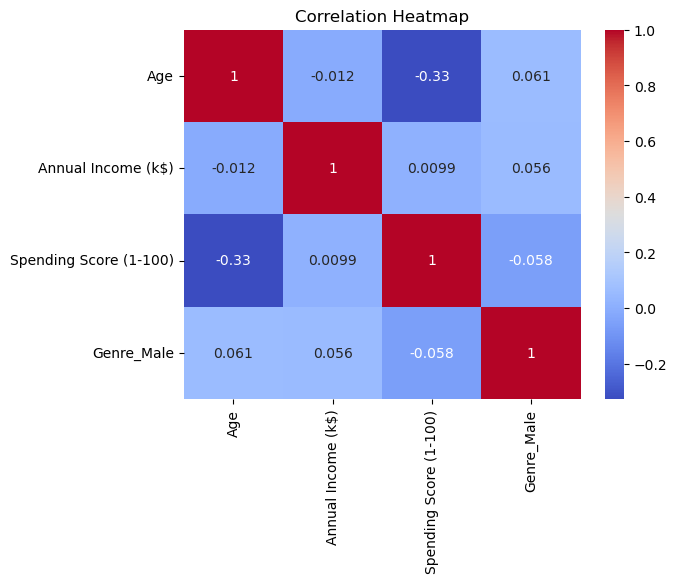

In [61]:
data = pd.get_dummies(data, columns=['Genre'],drop_first=True, dtype='int')
print(data)
sns.heatmap(data.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

#from sklearn.compose import ColumnTransformer
#from sklearn.preprocessing import StandardScaler, OneHotEncoder
#ct = ColumnTransformer([("scaling", StandardScaler(),['Age', 'Annual Income (k$)', 'Spending Score (1-100)']),
 #                      ('onehot', OneHotEncoder(sparse_output=False), ['Genre'])])

C:\Users\EricDiep\anaconda3\envs\ensf-ml\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\EricDiep\anaconda3\envs\ensf-ml\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\EricDiep\anaconda3\envs\ensf-ml\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


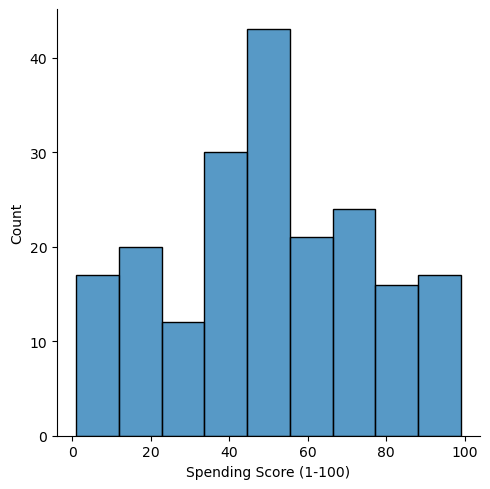

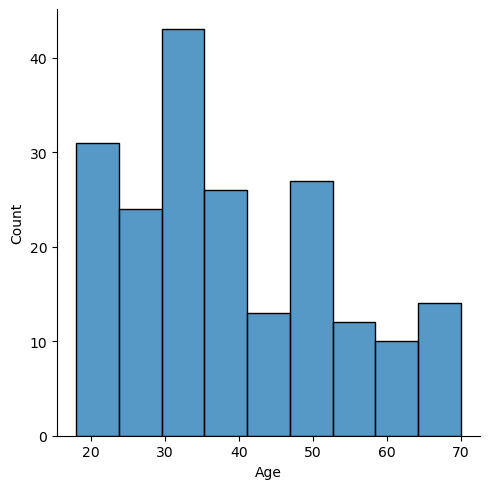

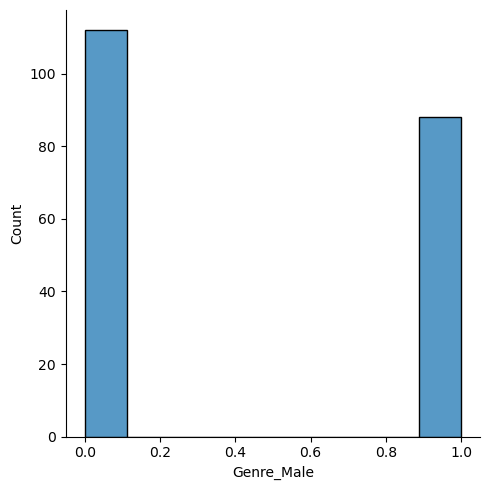

In [62]:
sns.displot(data['Spending Score (1-100)'])
sns.displot(data['Age'])
sns.displot(data['Genre_Male'])

### Questions (2 marks)

1. (1 mark) Were there any missing/null values in your dataset? If yes, how did you replace them and why? If no, describe how you would've replaced them and why.
2. (1 mark) What type of data do you have? What preprocessing methods would you have to apply based on your data types?

*ANSWER HERE*
1. There were no missing value in the data. The whole records (rows) would be dropped if any value (even one cell) is missing because the data in each columns is not completely unrelated to each other. And there's no way to estimate the missing value that is "meaninful" to the target vector.

2. 3 columns is numeric, and one column is categorical representing gender. One hot encoding is used for this gender column. Standard scaling is also used although it may not be required. Note that columns transformer is not used because the encoder is used separately first to draw the correlation map above. The column transformer command is comment out int the code above

## Step 3: Implement Machine Learning Model (11 marks)

In this section, you will implement three different supervised learning models (one linear and two non-linear) of your choice. You will use a pipeline to help you decide which model and hyperparameters work best. It is up to you to select what models to use and what hyperparameters to test. You can use the class examples for guidance. You must print out the best model parameters and results after the grid search.

In [66]:
# Implement pipeline and grid search here. Can add more code blocks if necessary

# Define 'X' and 'y'
X = data.drop(columns=['Spending Score (1-100)'])  # 'X' contains all features except 'Spending Score
y = data['Spending Score (1-100)']  # 'y' contains the 'Spending Score' column

X_train, X_test, y_train, y_test = train_test_split(X,y)

print(X.head())
print('X data types', X.dtypes)
print(y.head())
print('y data type', y.dtypes)

# Ridge Regression Pipeline
ridge_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', Ridge())
])

# Random Forest Pipeline
rf_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestRegressor())
])

# SVM Pipeline
svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVR())
])


# Define parameter grids
param_grid_rf = {
    'rf__n_estimators': [100, 200, 300, 400],
    'rf__max_depth': [5, 10, 15, 20, 30]
}

param_grid_ridge = {
    'ridge__alpha': [0.01, 0.1, 1, 10, 100],    
    'ridge__solver': ['cholesky', 'saga']  
}

param_grid_svm = {
    'svm__C': [0.01 ,0.1, 1, 10, 100],
    'svm__kernel': ['linear', 'rbf']
}

# Create GridSearchCV instances for each algorithm with multiple scoring metrics
grid_search_rf = GridSearchCV(rf_pipeline, param_grid_rf, cv=5, scoring = 'r2')
grid_search_ridge = GridSearchCV(ridge_pipeline, param_grid_ridge, cv=5, scoring = 'r2')
grid_search_svm = GridSearchCV(svm_pipeline, param_grid_svm, cv=5, scoring = 'r2')

# Fit the models
grid_search_rf.fit(X_train, y_train)
grid_search_ridge.fit(X_train, y_train)
grid_search_svm.fit(X_train, y_train)

# Get the best parameters based on F1
best_params_rf = grid_search_rf.best_params_
best_params_ridge = grid_search_ridge.best_params_
best_params_svm = grid_search_svm.best_params_

# Access the results for both scoring metrics
results_rf = grid_search_rf.cv_results_
results_ridge = grid_search_ridge.cv_results_
results_svm = grid_search_svm.cv_results_




   Age  Annual Income (k$)  Genre_Male
0   19                  15           1
1   21                  15           1
2   20                  16           0
3   23                  16           0
4   31                  17           0
X data types Age                   int64
Annual Income (k$)    int64
Genre_Male            int32
dtype: object
0    39
1    81
2     6
3    77
4    40
Name: Spending Score (1-100), dtype: int64
y data type int64


In [67]:
# Print the results for accuracy and F1
print("Random Forest Results:")
print('Best score: ', grid_search_rf.best_score_)
print("Best Parameters for Random Forest:", best_params_rf)

print("\nRidge Regression Results:")
print('Best score: ', grid_search_ridge.best_score_)
print("Best Parameters for Ridge Regression:", best_params_ridge)

print("\nSVM Results:")
print('Best score: ', grid_search_svm.best_score_)
print("Best Parameters for SVM:", best_params_svm)

Random Forest Results:
Best score:  0.25511355634019617
Best Parameters for Random Forest: {'rf__max_depth': 5, 'rf__n_estimators': 200}

Ridge Regression Results:
Best score:  0.06846824572235681
Best Parameters for Ridge Regression: {'ridge__alpha': 10, 'ridge__solver': 'cholesky'}

SVM Results:
Best score:  0.19385552354574184
Best Parameters for SVM: {'svm__C': 100, 'svm__kernel': 'rbf'}


### Questions (5 marks)

1. (1 mark) Do you need regression or classification models for your dataset?
1. (2 marks) Which models did you select for testing and why?
1. (2 marks) Which model worked the best? Does this make sense based on the theory discussed in the course and the context of your dataset?

*ANSWER HERE*
1. Regression is performed in this data set as spending score is a continuous value
2. A linear model is chosen to start with for its simplicity. Since linear regression doesn't have much parameter to tune with. Ridge is chosen so alpha can be tuned. Then, the model chosen is increasing in complexity, thus random forest and SVR are picked. Note that these model do have hyperparameters to perform a grid operation on.
3. Random forest model work the best although its score is still very low at 0.26. 
It makes sense that Ridge has the lowest score at 0.07 since this dataset only has 3 features (age, gender and income) and Ridge would bring all the features close to 0. There is simply too few feature for Ridge. Also, the data simply doens't work with Linear model.

SVM performs a bit better at 0.19. The more complexity of the model explains for the better performance when comparing to Ridge.




## Step 4: Validate Model (6 marks)

Use the testing set to calculate the testing accuracy for the best model determined in Step 3.

In [70]:
# Calculate testing accuracy (1 mark)
print("Random Forest Results:")
print('Training score: ', grid_search_rf.best_score_)
print("Testing Score: ", grid_search_rf.score(X_test, y_test))



print("\nRidge Regression Results:")
print('Training score: ', grid_search_ridge.best_score_)
print("Testing Score: ", grid_search_ridge.score(X_test, y_test))

print("\nSVM Results:")
print('Training score: ', grid_search_svm.best_score_)
print("Testing Score: ", grid_search_svm.score(X_test, y_test))

Random Forest Results:
Training score:  0.25511355634019617
Testing Score:  0.28767989000412764

Ridge Regression Results:
Training score:  0.06846824572235681
Testing Score:  0.11483855369856544

SVM Results:
Training score:  0.19385552354574184
Testing Score:  0.3263301681306471



### Questions (5 marks)

1. (1 mark) Which accuracy metric did you choose? 
1. (1 mark) How do these results compare to those in part 3? Did this model generalize well?
1. (3 marks) Based on your results and the context of your dataset, did the best model perform "well enough" to be used out in the real-world? Why or why not? Do you have any suggestions for how you could improve this analysis?

*ANSWER HERE*
1. R2 score is chosen.
2. The testing score is higher than the best training score in three models. As discussed in class, training score should be higher than the testing score usually. So this is a very strange case, that the models do not generalize well.
3. The models chosen performed super poor to be used. It is possible that the dataset simply doesnot work with these models. Different models such as k-neibor can be explored to see if they can give better results. Note that there are only three features and 200 records in the dataset, perhap more features and more data will help, but note that collecting more data features can be an expensive and difficult task. Finally, there may be other scaling and preprocessing methods that would improve the results although less likely due to the limit number of features and records available.

## Process Description (4 marks)
Please describe the process you used to create your code. Cite any websites or generative AI tools used. You can use the following questions as guidance:
1. Where did you source your code?
1. In what order did you complete the steps?
1. If you used generative AI, what prompts did you use? Did you need to modify the code at all? Why or why not?
1. Did you have any challenges? If yes, what were they? If not, what helped you to be successful?

*DESCRIBE YOUR PROCESS HERE*
1.The code is sourced mostly from lab#6 (classification) with modification found from googling and chatGPT in order to make it work for regression. 
2. I follow the order in the Machine Leanring Workflow. Loading data, inspect and cleaning data, split the data into train and test, set up the grid and its parameter, load the model and instantiate the ML model,  validate the model.
3. The AI prompt used was "please provide an example of ridge regression using pipeline and gridsearch, parameter grid". Modification of the AI code is needed because it is not exactly in the format that I need but it gives me a direction and idea about how things work
4. I found it difficult to find a good dataset that I like and meet the requirement of the assigment. I found it helpful talking to my peers, and after reading many articles online.


## Reflection (2 marks)
Include a sentence or two about:
- what you liked or disliked,
- found interesting, confusing, challenging, motivating
while working on this assignment.


*ADD YOUR THOUGHTS HERE*
I didn't like the data searching part. It was quite tedious. The grid parameters part is confusing as different models require different parameter. But it is a good assignment to read through the documenatation to have a good undestanding. Also, the result is very strange that the testing score is higher than the training score. It's challenging to find out why. 